# BASELINE MODELS IMAGE

In [1]:
import os
import shutil
import random
from PIL import Image, ImageEnhance
from sklearn.utils import resample
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import itertools
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectPercentile
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, make_scorer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import umap.umap_ as umap
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# options d'affichage
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Réduction PCA + Decision Tree Classifier (Random Forest, XGBoost)

## Preprocessing 1 : Redimensionnement

#### Cette étape consiste à: 
- passer d'images de 500x500 pixels à 64x64 pixels
- sélectionner 500 images par catégorie (27) soit 13500 images
- Passer les images en niveaux de gris

In [4]:
# path du dossier images
base_dir = "../data/processed/balanced_image_train"
# taille des img
image_size = (64, 64)
# listes pour img et labels
images = []
labels = []
# max images à sélectionner par catégorie
max_img = 500
# dict comptage img par catégorie
image_count = {}
# Chargement images et labels
for category in os.listdir(base_dir):
    category_dir = os.path.join(base_dir, category)
    if os.path.isdir(category_dir):
        image_count[category] = 0
        for file_name in os.listdir(category_dir):
            if image_count[category] < max_img:  # Limiter à 1000 images par catégorie
                img_path = os.path.join(category_dir, file_name)
                img = load_img(img_path, target_size = image_size, color_mode = 'grayscale')
                img_array = img_to_array(img)
                images.append(img_array)
                labels.append(category)
                image_count[category] += 1
            else:
                break

# Conversion en tableaux numpy
images = np.array(images)
labels = np.array(labels)
# Redimensionnement img 2D
images = images.reshape(images.shape[0], -1)

print(f"Nb total d'images chargées: {len(images)}")
for category, count in image_count.items():
    print(f"Category {category}: {count} images loaded")
print("imgs shape : ", images.shape)
print("labels shape : ", labels.shape)

Nb total d'images chargées: 13500
Category 10: 500 images loaded
Category 1140: 500 images loaded
Category 1160: 500 images loaded
Category 1180: 500 images loaded
Category 1280: 500 images loaded
Category 1281: 500 images loaded
Category 1300: 500 images loaded
Category 1301: 500 images loaded
Category 1302: 500 images loaded
Category 1320: 500 images loaded
Category 1560: 500 images loaded
Category 1920: 500 images loaded
Category 1940: 500 images loaded
Category 2060: 500 images loaded
Category 2220: 500 images loaded
Category 2280: 500 images loaded
Category 2403: 500 images loaded
Category 2462: 500 images loaded
Category 2522: 500 images loaded
Category 2582: 500 images loaded
Category 2583: 500 images loaded
Category 2585: 500 images loaded
Category 2705: 500 images loaded
Category 2905: 500 images loaded
Category 40: 500 images loaded
Category 50: 500 images loaded
Category 60: 500 images loaded
imgs shape :  (13500, 4096)
labels shape :  (13500,)


## Affichage du preprocessing

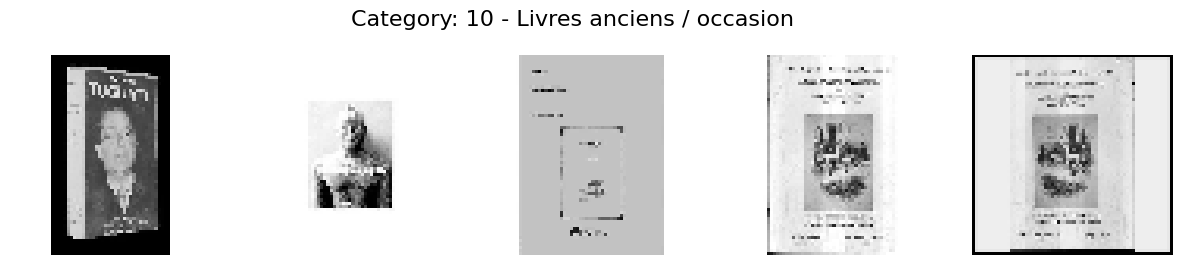

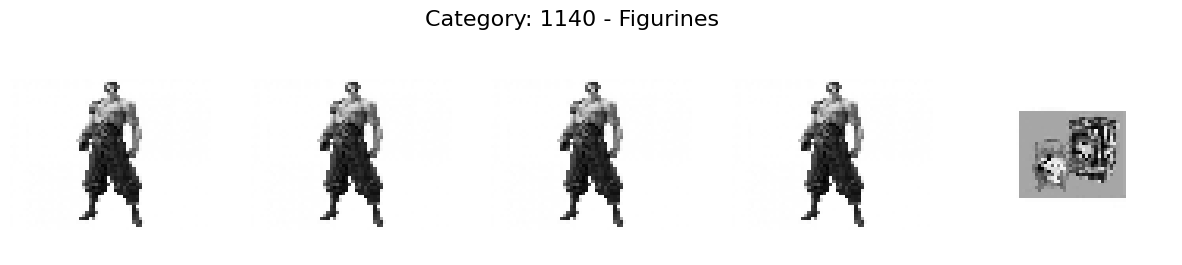

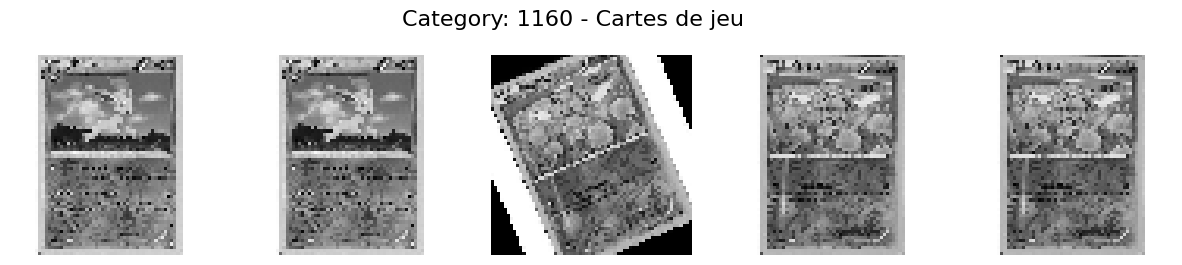

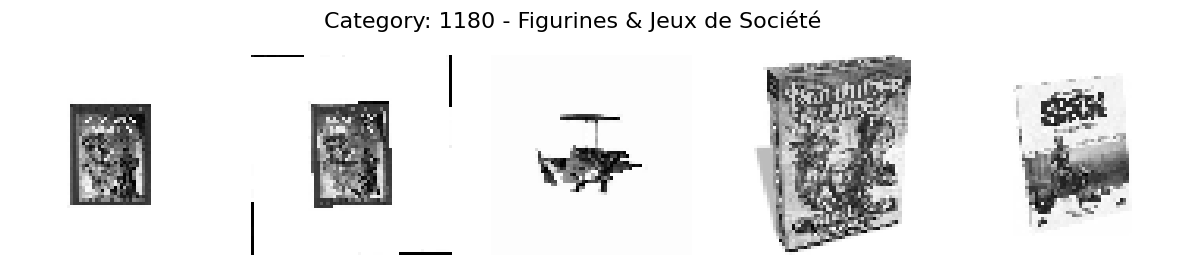

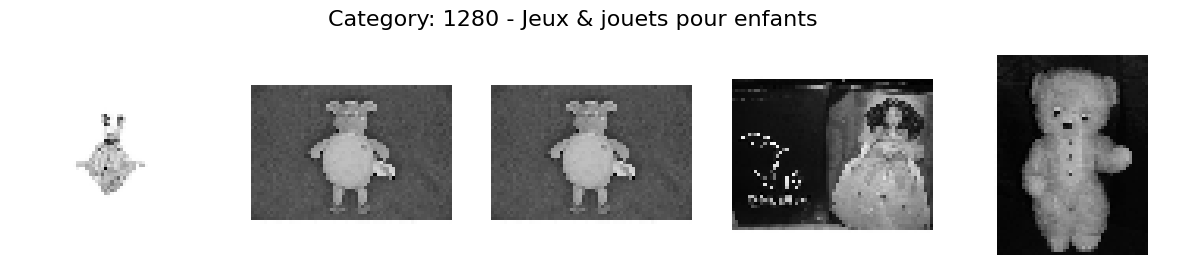

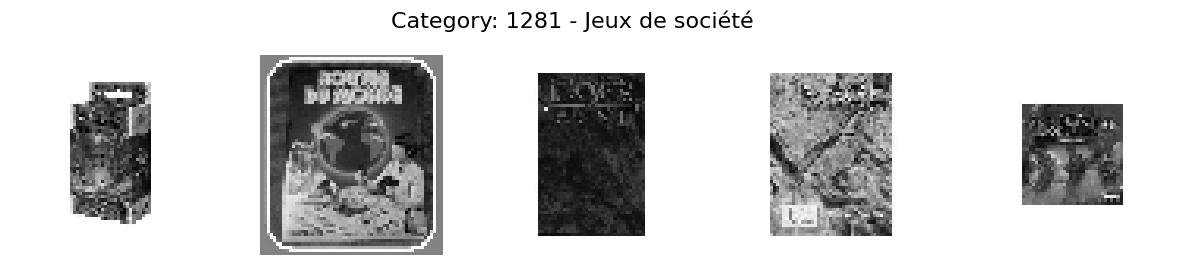

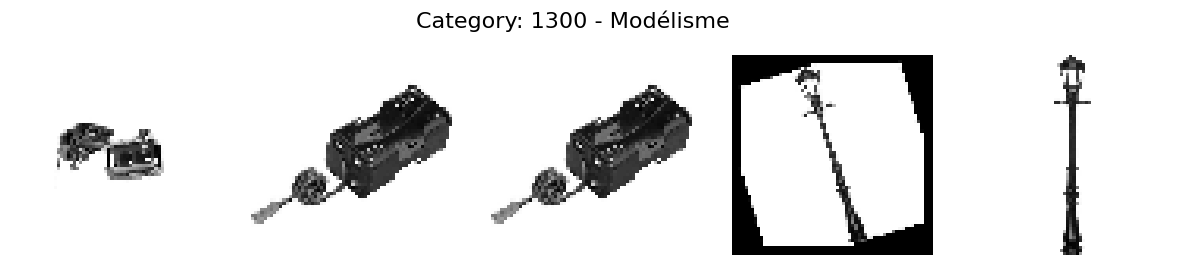

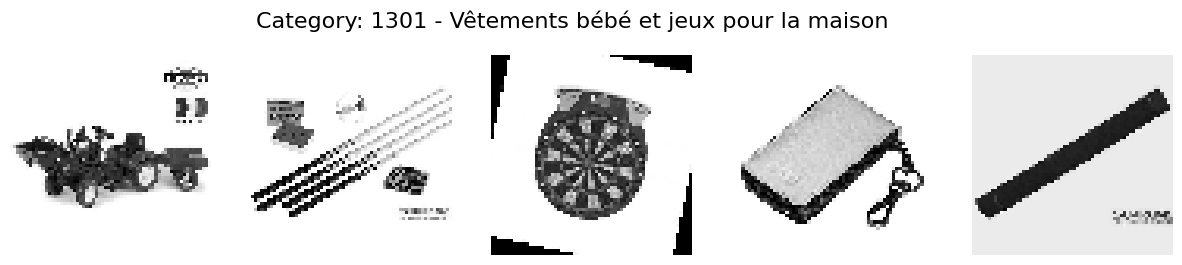

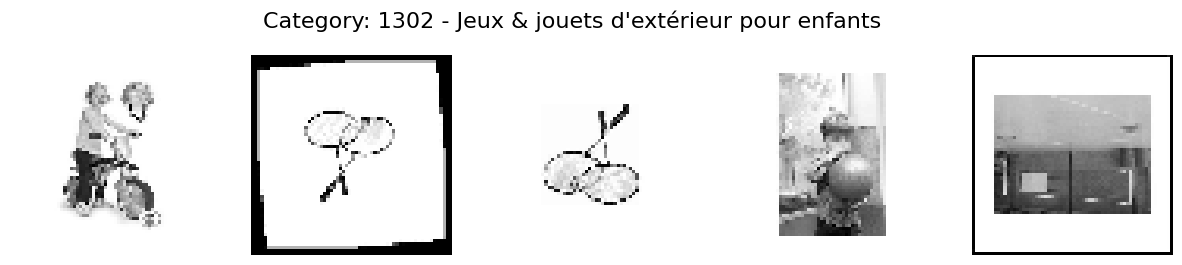

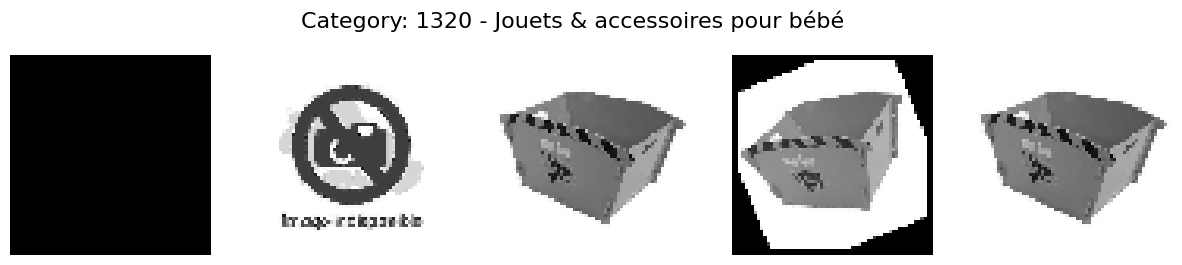

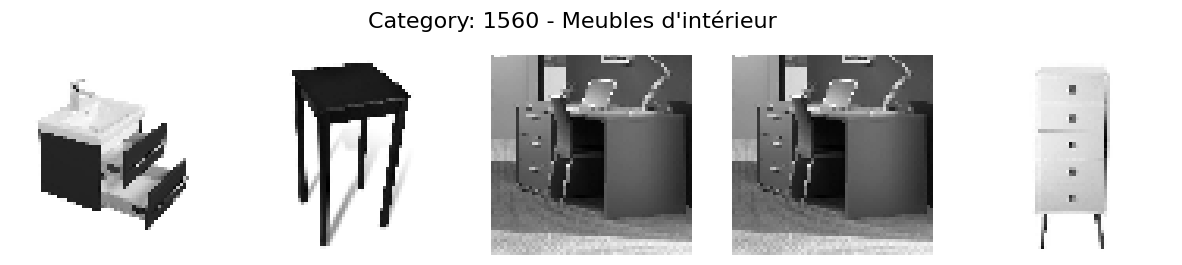

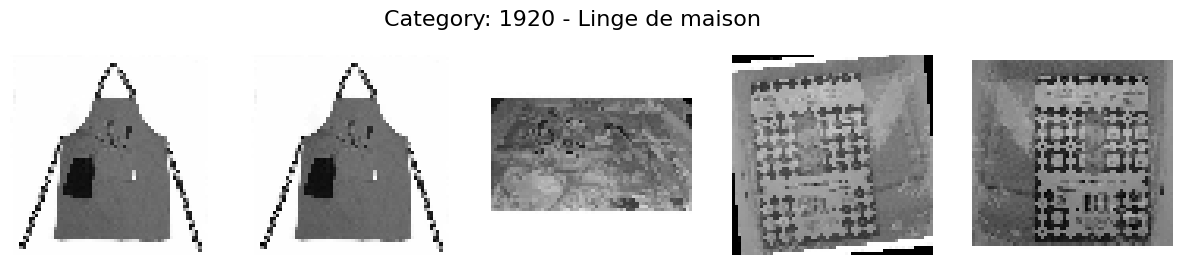

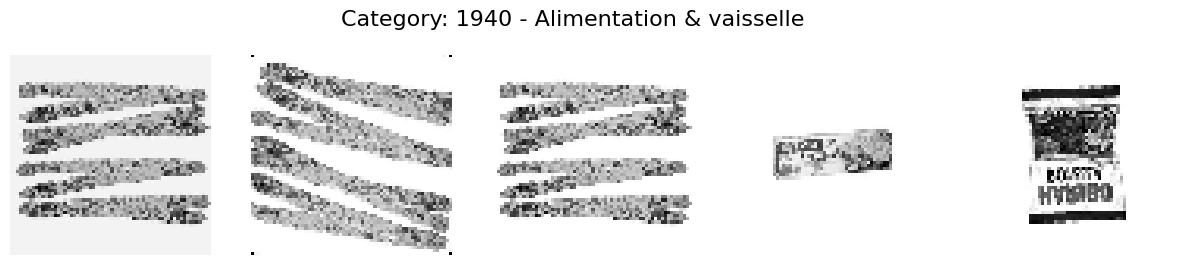

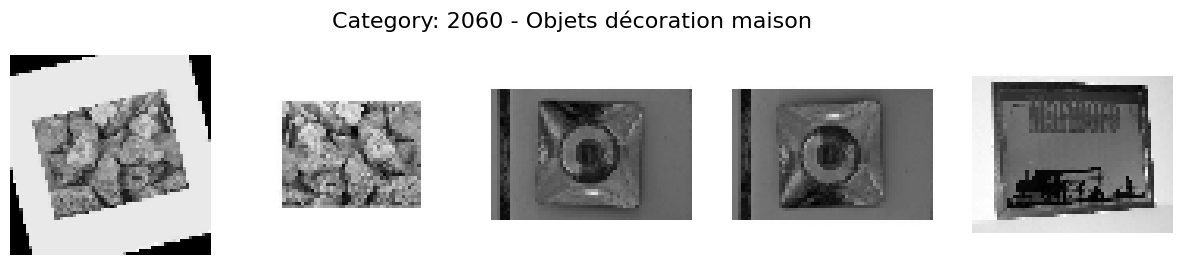

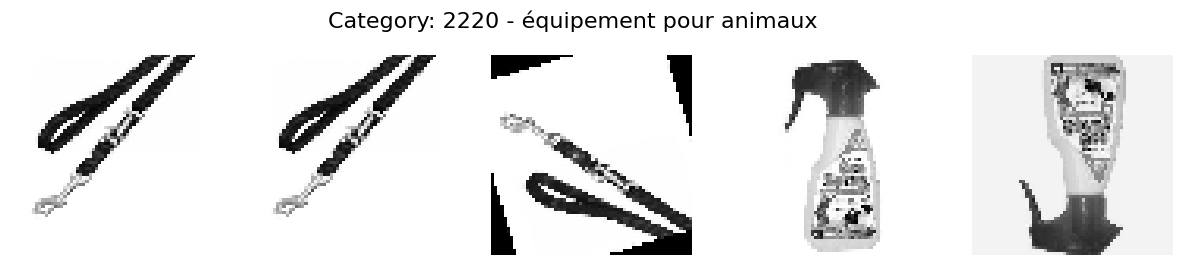

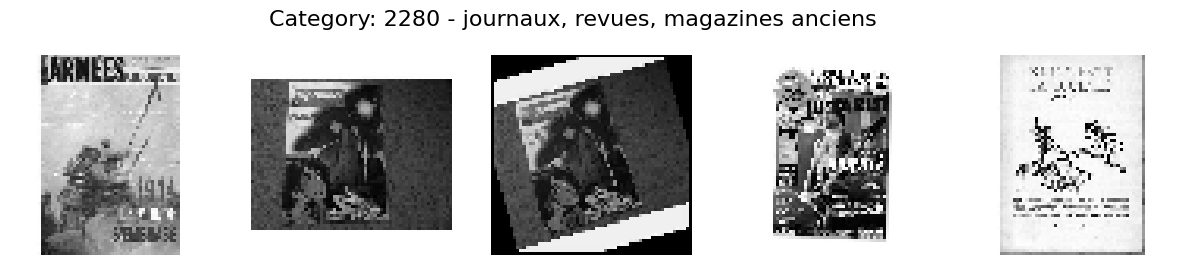

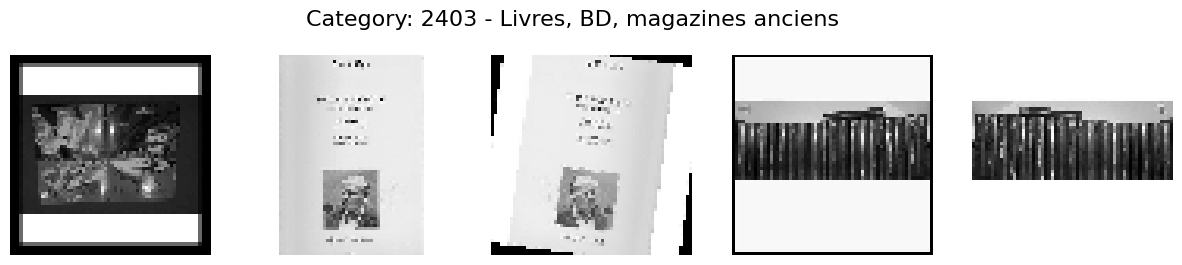

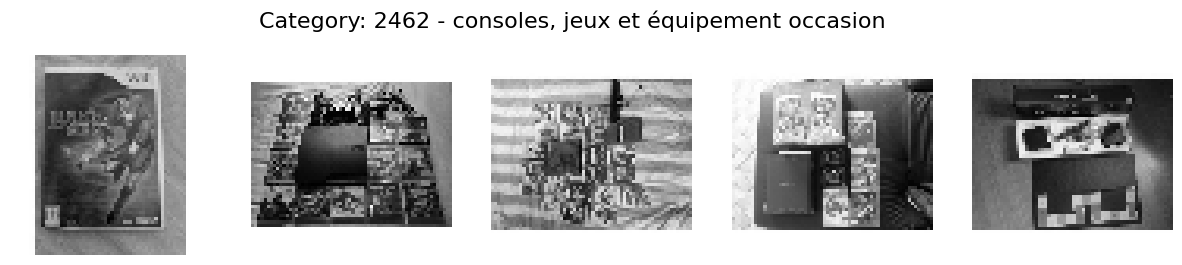

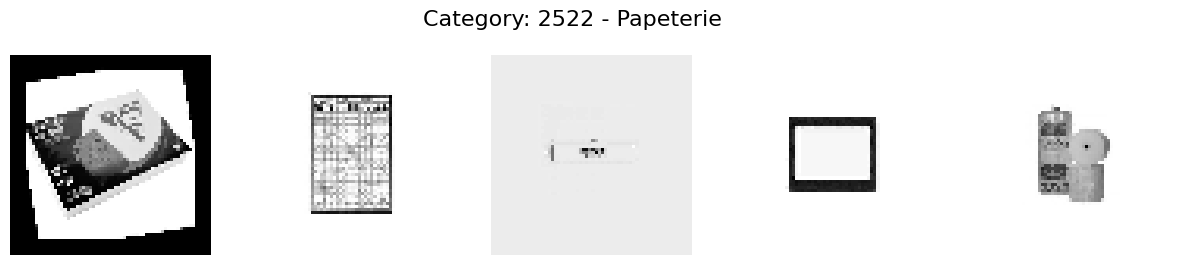

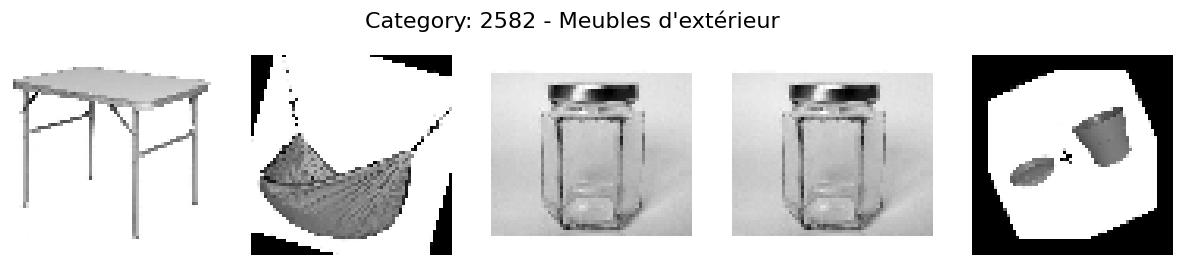

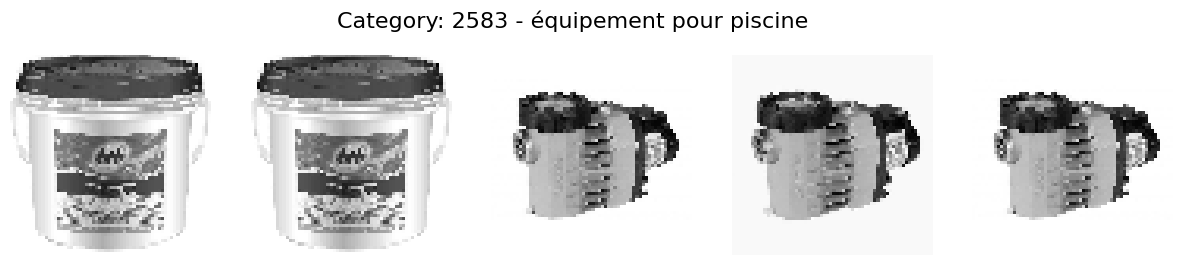

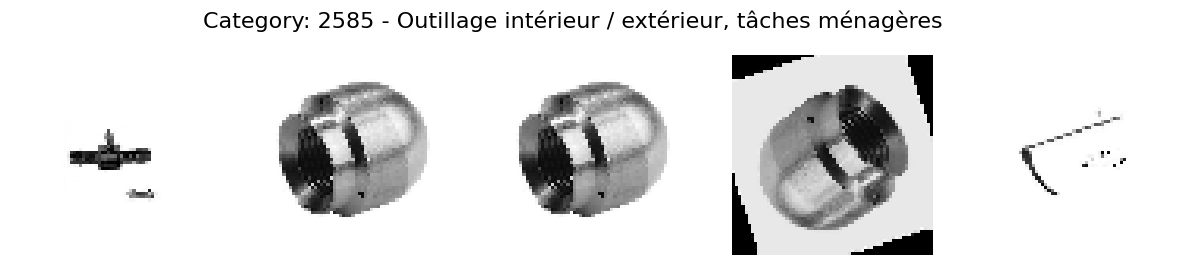

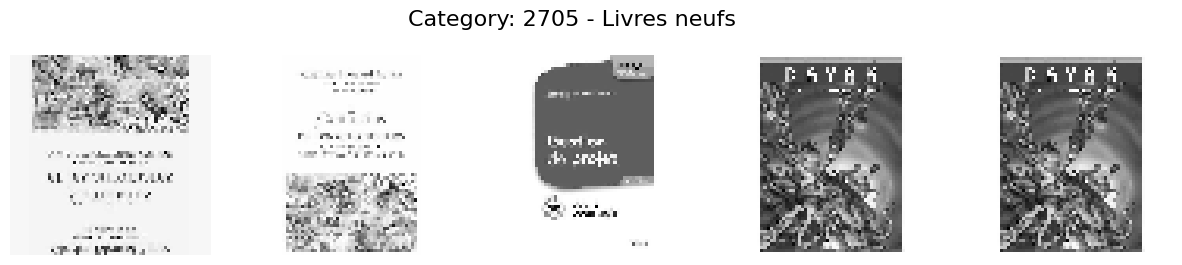

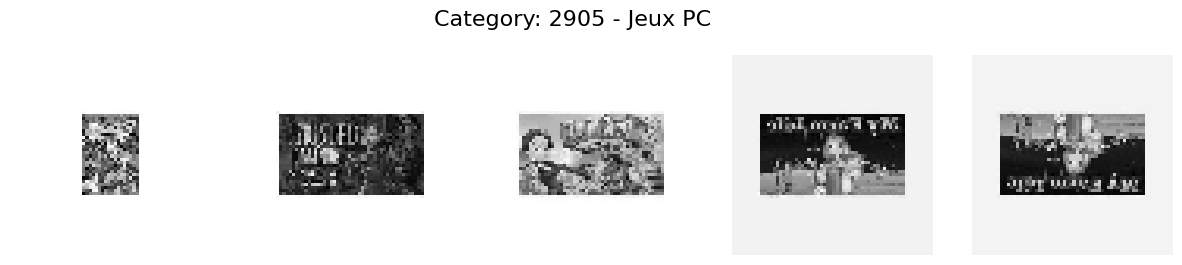

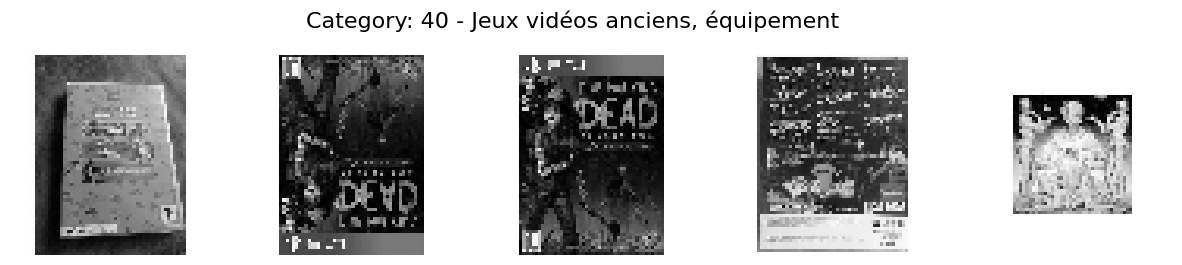

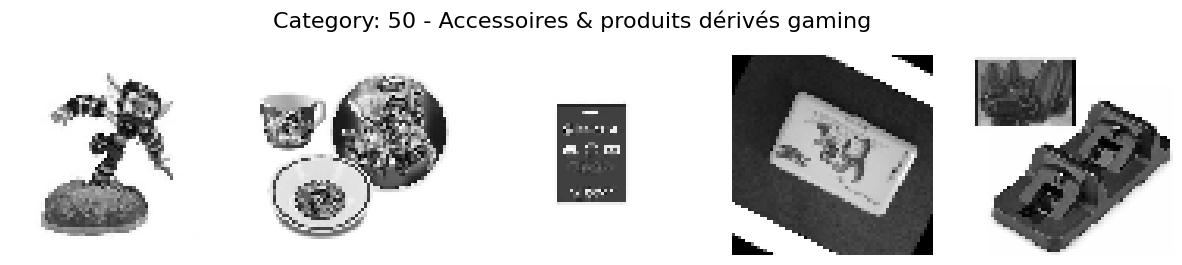

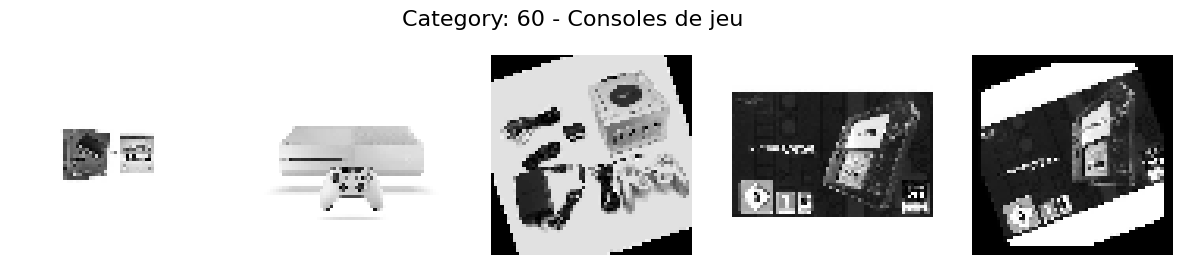

In [7]:
# Afficher les images réduites

data = pd.read_csv('../data/csv_files/img-data.csv')

# Taille originale des images
original_shape = (64, 64, 1)

# nb max d'images à afficher
max_img_display = 5

# dict prdtypecode -> designation textuelle
category_to_text = dict(zip(data['prdtypecode'], data['désignation textuelle']))

# dict imgs par catégorie
images_by_category = defaultdict(list)
# replissage du dict imgs par catégorie
for img, label in zip(images, labels):
    if len(images_by_category[label]) < max_img_display:
        images_by_category[label].append(img)

# Affichage
for category, imgs in images_by_category.items():
    plt.figure(figsize = (15, 3))
    # designation textuelle associée à la catégorie
    text_designation = category_to_text.get(int(category), "Unknown")
    plt.suptitle(f"Category: {category} - {text_designation}", fontsize = 16)
    
    for i in range(len(imgs)):
        reshaped_img = imgs[i].reshape(original_shape)
        plt.subplot(1, 5, i + 1)
        plt.imshow(reshaped_img.astype("uint8"), cmap = 'gray')
        plt.axis('off')
    
    plt.show()


# Application de la PCA

- Graphique 1 : Variance expliquée par nombre de composantes
- Graphique 2 : Variance expliquée par nombre de composantes cumulées

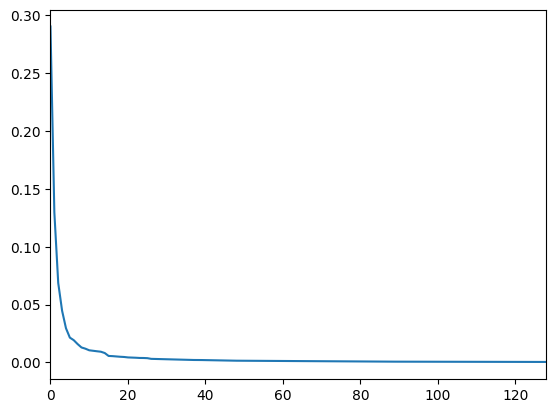

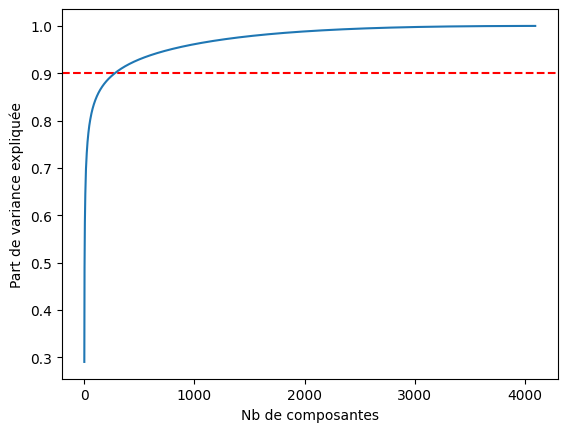

In [15]:
pca = PCA()
pca.fit(images)

# Affichage graph 1
plt.figure()
plt.xlim(0, 128)
plt.plot(pca.explained_variance_ratio_)
plt.show()

# Affichage graph 2
plt.figure()
plt.xlabel('Nb de composantes')
plt.ylabel('Part de variance expliquée')
plt.axhline(y = 0.9, color = 'r', linestyle = '--')
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.show()


In [11]:
pca = PCA(n_components = 0.9)
images_pca = pca.fit_transform(images)
print(f"Variance expliquée par les {pca.n_components_} premières composantes : {sum(pca.explained_variance_ratio_):.2f}")

Variance expliquée par les 278 premières composantes : 0.90


D'après les graphiques précédents et l'application de la méthode PCA, il faut 278 composantes pour conserver 90% de la variance expliquée dans les images du jeu de données réduit.
On est donc passé de 4096 features (64x64) à 278.

## Encodage des labels

In [8]:
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

## Division du jeu de données

In [13]:
X_train, X_test, y_train, y_test = train_test_split(images_pca, labels_encoded, test_size = 0.2, random_state = 42)

## Entraînement d'un Random Forest Classifier

Justifications du choix:
- Les Random Forest offrent généralement de bonnes performances sur des jeux de données complexes / bruyants, ce qui est notre cas
- Ils agrégent les prédictions sur plusieurs sous-échantillons de données, ce qui réduit le risque d'overfitting
- Ils sont résistants aux déséquilibres de classes

On va d'abord tester l'accuracy du RF sur plusieurs valeurs de n_estimators (nombre de souches) pour trouver la meilleure valeur

n_estimators = 10: Accuracy = 0.4337
n_estimators = 50: Accuracy = 0.4670
n_estimators = 100: Accuracy = 0.4863
n_estimators = 200: Accuracy = 0.4941
n_estimators = 300: Accuracy = 0.4926
n_estimators = 400: Accuracy = 0.4963


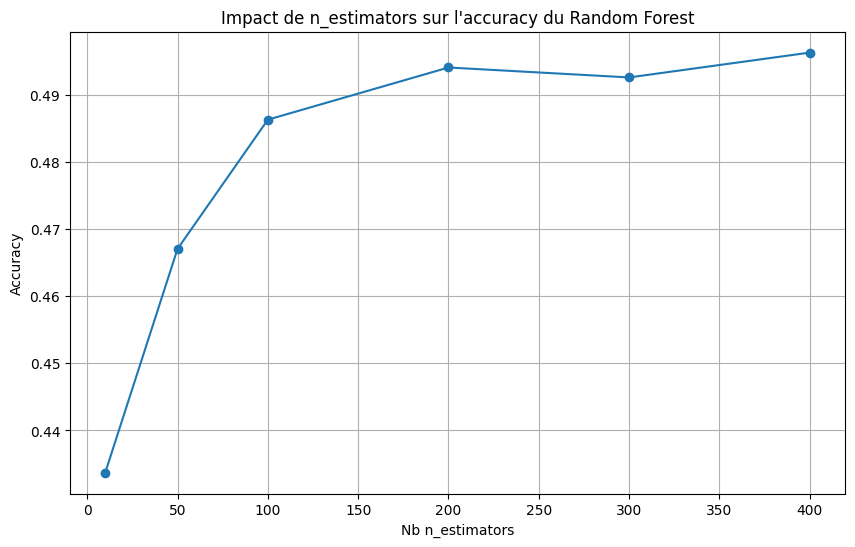

In [30]:
# Liste des valeurs de n_estimators à tester
n_estimators_range = [10, 50, 100, 200, 300, 400]

# Liste des accuracy pour chaque n_estimators
accuracy_scores = []

for n in n_estimators_range:
    # Entraînement du modèle RF avec n_estimators
    rf = RandomForestClassifier(n_estimators=n, random_state=42)
    rf.fit(X_train, y_train)

    # Prédictions sur l'ensemble de test
    y_pred = rf.predict(X_test)

    # Calcul de l'accuracy
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)

    # Affichage des résultats
    print(f"n_estimators = {n}: Accuracy = {accuracy:.4f}")

# Affichage graphqiue des performances
plt.figure(figsize = (10, 6))
plt.plot(n_estimators_range, accuracy_scores, marker = 'o')
plt.title('Impact de n_estimators sur l\'accuracy du Random Forest')
plt.xlabel('Nb n_estimators')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()


On voit qu'après 200 souches, l'algorithme cesse sensiblement de converger. On peut donc en déduire que le nombre idéal de n_estimators est de 200.

In [14]:
# Entraînement du modèle RF
rf = RandomForestClassifier(n_estimators = 200, random_state = 42)
rf.fit(X_train, y_train)

# Prédictions sur l'ensemble de test
y_pred = rf.predict(X_test)

# Évaluation des performances
print("Random Forest Classifier:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Random Forest Classifier:
Accuracy: 0.49
              precision    recall  f1-score   support

          10       0.53      0.55      0.54       114
        1140       0.50      0.50      0.50       102
        1160       0.37      0.62      0.47       101
        1180       0.53      0.46      0.49        90
        1280       0.59      0.43      0.50       107
        1281       0.47      0.45      0.46        95
        1300       0.42      0.37      0.39       111
        1301       0.59      0.56      0.57        97
        1302       0.54      0.40      0.46       107
        1320       0.44      0.51      0.47        94
        1560       0.40      0.45      0.43        95
        1920       0.52      0.61      0.56       101
        1940       0.46      0.45      0.46       100
        2060       0.40      0.53      0.46        88
        2220       0.50      0.37      0.42       101
        2280       0.53      0.71      0.61        84
        2403       0.47      0.45      0

## Visualisation des résultats

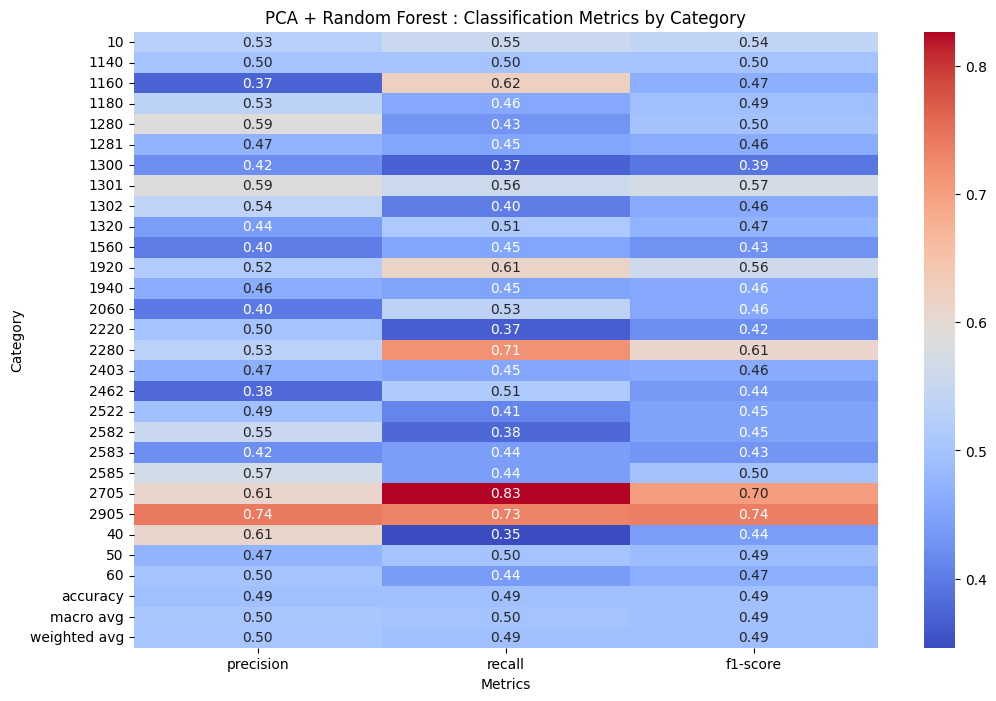

In [17]:
def heatmap_metrics_by_category(report, model):
    '''
    - desc: Affiche une heatmap du classification report (precision, recall, f1-score) de la lib sklearn.metrics
    - params:
     -> report
     -> model : modèle utilisé
    '''

    # Conversion en df
    df = pd.DataFrame(report).transpose()

    # Heatmap
    plt.figure(figsize = (12, 8))
    sns.heatmap(df.iloc[:, :-1], annot = True, fmt = '.2f', cmap = 'coolwarm')
    plt.xlabel('Metrics')
    plt.ylabel('Category')
    plt.title(f'{model} : Classification Metrics by Category')
    plt.show()

# dict classification_report
report_rf = classification_report(y_test, y_pred, target_names = label_encoder.classes_, output_dict = True)
heatmap_metrics_by_category(report_rf, 'PCA + Random Forest')

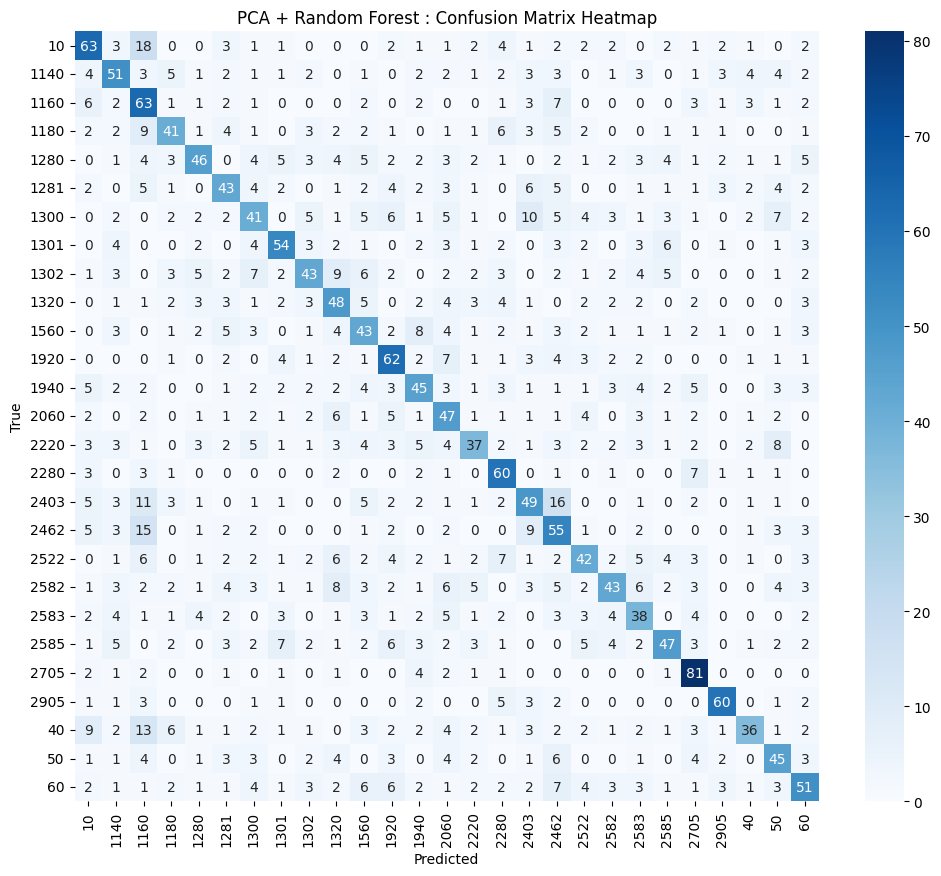

In [18]:
# matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# noms des classes
class_names = label_encoder.classes_

plt.figure(figsize = (12, 10))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = class_names, yticklabels = class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('PCA + Random Forest : Confusion Matrix Heatmap')
plt.show()

## Conclusions:

- Avec une accuracy de 0.49 et un f1-score autour de 0.49 également, on peut en conclure que le modèle classe environ 50% des images dans la bonne catégorie, ce qui est un score relativement faible
- Cela peut être dû à la réduction de dimension qui est trop importante, néanmoins avec la configuration locale sur laquelle ont été effectués cette PCA + entraînemnt, c'était déjà assez gourmand en mémoire et en temps d'éxécution
- On constate une certaine variabilité entre les classes:
1) les classes 2705 et 2905 (respectivement "livres neufs" et "jeux PC") obtiennent d'assez bon résultats (entre 0.67 et 0.77 sur toutes les métriques)
2) La classe 1300 (respectivement "Modélisme") obtient des scores assez faibles sur toutes les métriques (autour de 0.35), ce qui est également le cas pour les modèles de classification de texte. Elle est souvent confondue avec la classe 2403 : Livres, BD, magazines anciens 

L'entraînement a duré 1m48 sur une config PC classique (16Go RAM, core i7)
 

## Entraînement d'un XGBoost

Justifications du choix:
- Nombreux hyperparamètres
- performances réputées
- mécanismes de pondération et d'ajustement pour les données déséquilibrées

On va d'abord tester l'accuracy du XGBoost avec plusieurs valeurs d'hyperparamètres, puis nous sélectionnerons la meilleure combinaison.

In [36]:
# valeurs de paramètres à tester
learning_rates = [0.01, 0.1, 0.2]
n_estimators_list = [50, 100, 200]
max_depths = [3, 5, 7]

# Stockage des résultats
results = []

for lr, n_est, max_depth in itertools.product(learning_rates, n_estimators_list, max_depths):
    print(f"Testing with learning_rate = {lr}, n_estimators = {n_est}, max_depth = {max_depth}")
    
    # fit
    xgb = XGBClassifier(use_label_encoder = False,
                        eval_metric = 'mlogloss',
                        learning_rate = lr,
                        n_estimators = n_est,
                        max_depth = max_depth,
                        n_jobs = -1,
                        objective='multi:softprob',
                        random_state = 42)
    xgb.fit(X_train, y_train)
    
    # prediction
    y_pred_xgb = xgb.predict(X_test)
    
    # perf
    accuracy = accuracy_score(y_test, y_pred_xgb)
    report = classification_report(y_test, y_pred_xgb, target_names = label_encoder.classes_, output_dict = True)
    results.append({
        'learning_rate': lr,
        'n_estimators': n_est,
        'max_depth': max_depth,
        'accuracy': accuracy,
        'f1_macro_avg': report['macro avg']['f1-score'],
        'f1_weighted_avg': report['weighted avg']['f1-score']
    })

    # Affichage intermédiaire
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Macro Avg F1-Score: {report['macro avg']['f1-score']:.2f}")
    print(f"Weighted Avg F1-Score: {report['weighted avg']['f1-score']:.2f}")
    print("-" * 60)

# conversion results en DataFrame
results_df = pd.DataFrame(results)

# affichage meilleurs paramètres
best_result = results_df.loc[results_df['accuracy'].idxmax()]
print(f"\nBest Parameters based on Accuracy:\n{best_result}")


Testing with learning_rate = 0.01, n_estimators = 50, max_depth = 3


c:\Users\Louis Valentin\source\repos\bootcamp-mle24-rakuten\env\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:00:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "ax_depth", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.34
Macro Avg F1-Score: 0.33
Weighted Avg F1-Score: 0.33
------------------------------------------------------------
Testing with learning_rate = 0.01, n_estimators = 50, max_depth = 5


c:\Users\Louis Valentin\source\repos\bootcamp-mle24-rakuten\env\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:02:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "ax_depth", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.34
Macro Avg F1-Score: 0.33
Weighted Avg F1-Score: 0.33
------------------------------------------------------------
Testing with learning_rate = 0.01, n_estimators = 50, max_depth = 7


c:\Users\Louis Valentin\source\repos\bootcamp-mle24-rakuten\env\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:04:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "ax_depth", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.34
Macro Avg F1-Score: 0.33
Weighted Avg F1-Score: 0.33
------------------------------------------------------------
Testing with learning_rate = 0.01, n_estimators = 100, max_depth = 3


c:\Users\Louis Valentin\source\repos\bootcamp-mle24-rakuten\env\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:05:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "ax_depth", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.38
Macro Avg F1-Score: 0.37
Weighted Avg F1-Score: 0.37
------------------------------------------------------------
Testing with learning_rate = 0.01, n_estimators = 100, max_depth = 5


c:\Users\Louis Valentin\source\repos\bootcamp-mle24-rakuten\env\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:09:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "ax_depth", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.38
Macro Avg F1-Score: 0.37
Weighted Avg F1-Score: 0.37
------------------------------------------------------------
Testing with learning_rate = 0.01, n_estimators = 100, max_depth = 7


c:\Users\Louis Valentin\source\repos\bootcamp-mle24-rakuten\env\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:13:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "ax_depth", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.38
Macro Avg F1-Score: 0.37
Weighted Avg F1-Score: 0.37
------------------------------------------------------------
Testing with learning_rate = 0.01, n_estimators = 200, max_depth = 3


c:\Users\Louis Valentin\source\repos\bootcamp-mle24-rakuten\env\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:17:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "ax_depth", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.43
Macro Avg F1-Score: 0.43
Weighted Avg F1-Score: 0.42
------------------------------------------------------------
Testing with learning_rate = 0.01, n_estimators = 200, max_depth = 5


c:\Users\Louis Valentin\source\repos\bootcamp-mle24-rakuten\env\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:25:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "ax_depth", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.43
Macro Avg F1-Score: 0.43
Weighted Avg F1-Score: 0.42
------------------------------------------------------------
Testing with learning_rate = 0.01, n_estimators = 200, max_depth = 7


c:\Users\Louis Valentin\source\repos\bootcamp-mle24-rakuten\env\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:32:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "ax_depth", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.43
Macro Avg F1-Score: 0.43
Weighted Avg F1-Score: 0.42
------------------------------------------------------------
Testing with learning_rate = 0.1, n_estimators = 50, max_depth = 3


c:\Users\Louis Valentin\source\repos\bootcamp-mle24-rakuten\env\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:41:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "ax_depth", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.47
Macro Avg F1-Score: 0.47
Weighted Avg F1-Score: 0.46
------------------------------------------------------------
Testing with learning_rate = 0.1, n_estimators = 50, max_depth = 5


c:\Users\Louis Valentin\source\repos\bootcamp-mle24-rakuten\env\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:42:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "ax_depth", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.47
Macro Avg F1-Score: 0.47
Weighted Avg F1-Score: 0.46
------------------------------------------------------------
Testing with learning_rate = 0.1, n_estimators = 50, max_depth = 7


c:\Users\Louis Valentin\source\repos\bootcamp-mle24-rakuten\env\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:44:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "ax_depth", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.47
Macro Avg F1-Score: 0.47
Weighted Avg F1-Score: 0.46
------------------------------------------------------------
Testing with learning_rate = 0.1, n_estimators = 100, max_depth = 3


c:\Users\Louis Valentin\source\repos\bootcamp-mle24-rakuten\env\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:47:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "ax_depth", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.48
Macro Avg F1-Score: 0.48
Weighted Avg F1-Score: 0.48
------------------------------------------------------------
Testing with learning_rate = 0.1, n_estimators = 100, max_depth = 5


c:\Users\Louis Valentin\source\repos\bootcamp-mle24-rakuten\env\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:51:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "ax_depth", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.48
Macro Avg F1-Score: 0.48
Weighted Avg F1-Score: 0.48
------------------------------------------------------------
Testing with learning_rate = 0.1, n_estimators = 100, max_depth = 7


c:\Users\Louis Valentin\source\repos\bootcamp-mle24-rakuten\env\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:56:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "ax_depth", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.48
Macro Avg F1-Score: 0.48
Weighted Avg F1-Score: 0.48
------------------------------------------------------------
Testing with learning_rate = 0.1, n_estimators = 200, max_depth = 3


c:\Users\Louis Valentin\source\repos\bootcamp-mle24-rakuten\env\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:59:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "ax_depth", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.48
Macro Avg F1-Score: 0.48
Weighted Avg F1-Score: 0.48
------------------------------------------------------------
Testing with learning_rate = 0.1, n_estimators = 200, max_depth = 5


c:\Users\Louis Valentin\source\repos\bootcamp-mle24-rakuten\env\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:06:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "ax_depth", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.48
Macro Avg F1-Score: 0.48
Weighted Avg F1-Score: 0.48
------------------------------------------------------------
Testing with learning_rate = 0.1, n_estimators = 200, max_depth = 7


c:\Users\Louis Valentin\source\repos\bootcamp-mle24-rakuten\env\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:14:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "ax_depth", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.48
Macro Avg F1-Score: 0.48
Weighted Avg F1-Score: 0.48
------------------------------------------------------------
Testing with learning_rate = 0.2, n_estimators = 50, max_depth = 3


c:\Users\Louis Valentin\source\repos\bootcamp-mle24-rakuten\env\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:20:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "ax_depth", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.47
Macro Avg F1-Score: 0.47
Weighted Avg F1-Score: 0.47
------------------------------------------------------------
Testing with learning_rate = 0.2, n_estimators = 50, max_depth = 5


c:\Users\Louis Valentin\source\repos\bootcamp-mle24-rakuten\env\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:22:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "ax_depth", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.47
Macro Avg F1-Score: 0.47
Weighted Avg F1-Score: 0.47
------------------------------------------------------------
Testing with learning_rate = 0.2, n_estimators = 50, max_depth = 7


c:\Users\Louis Valentin\source\repos\bootcamp-mle24-rakuten\env\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:23:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "ax_depth", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.47
Macro Avg F1-Score: 0.47
Weighted Avg F1-Score: 0.47
------------------------------------------------------------
Testing with learning_rate = 0.2, n_estimators = 100, max_depth = 3


c:\Users\Louis Valentin\source\repos\bootcamp-mle24-rakuten\env\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:25:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "ax_depth", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.48
Macro Avg F1-Score: 0.48
Weighted Avg F1-Score: 0.48
------------------------------------------------------------
Testing with learning_rate = 0.2, n_estimators = 100, max_depth = 5


c:\Users\Louis Valentin\source\repos\bootcamp-mle24-rakuten\env\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:29:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "ax_depth", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.48
Macro Avg F1-Score: 0.48
Weighted Avg F1-Score: 0.48
------------------------------------------------------------
Testing with learning_rate = 0.2, n_estimators = 100, max_depth = 7


c:\Users\Louis Valentin\source\repos\bootcamp-mle24-rakuten\env\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:33:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "ax_depth", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.48
Macro Avg F1-Score: 0.48
Weighted Avg F1-Score: 0.48
------------------------------------------------------------
Testing with learning_rate = 0.2, n_estimators = 200, max_depth = 3


c:\Users\Louis Valentin\source\repos\bootcamp-mle24-rakuten\env\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:37:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "ax_depth", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.49
Macro Avg F1-Score: 0.48
Weighted Avg F1-Score: 0.48
------------------------------------------------------------
Testing with learning_rate = 0.2, n_estimators = 200, max_depth = 5


c:\Users\Louis Valentin\source\repos\bootcamp-mle24-rakuten\env\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:42:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "ax_depth", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.49
Macro Avg F1-Score: 0.48
Weighted Avg F1-Score: 0.48
------------------------------------------------------------
Testing with learning_rate = 0.2, n_estimators = 200, max_depth = 7


c:\Users\Louis Valentin\source\repos\bootcamp-mle24-rakuten\env\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:48:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "ax_depth", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.49
Macro Avg F1-Score: 0.48
Weighted Avg F1-Score: 0.48
------------------------------------------------------------

Best Parameters based on Accuracy:
learning_rate        0.200000
n_estimators       200.000000
max_depth            3.000000
accuracy             0.485185
f1_macro_avg         0.484393
f1_weighted_avg      0.481368
Name: 24, dtype: float64


In [41]:
print(best_result['max_depth'])

3.0


Après analyse des résultats, les meilleurs paramètres semblent être:
- learning_rate : 0.2
- n_estimators : 200
- max_depth : 3  
Pour une accuracy globale de 0.49, qui ne fait guère mieux que le Random Forest Classifier.
On peut ré-entraîner le modèle avec ces paramètres:

In [19]:
xgb = XGBClassifier(use_label_encoder = False,
                    eval_metric = 'mlogloss', # car on traite un problème multi-classes
                    n_jobs = -1,
                    objective='multi:softprob',  # car on veut obtenir la classe avec les meilleures probas
                    random_state = 42,
                    learning_rate = 0.2,
                    n_estimators = 200,
                    max_depth = 3
                    )
xgb.fit(X_train, y_train)

# prédictions
y_pred_xgb = xgb.predict(X_test)

# Affichage des perf
print("XGBoost Classifier:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.2f}")
print(classification_report(y_test, y_pred_xgb, target_names=label_encoder.classes_))


c:\Users\Louis Valentin\source\repos\bootcamp-mle24-rakuten\env\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:53:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Classifier:
Accuracy: 0.48
              precision    recall  f1-score   support

          10       0.55      0.55      0.55       114
        1140       0.54      0.54      0.54       102
        1160       0.50      0.63      0.56       101
        1180       0.48      0.48      0.48        90
        1280       0.53      0.42      0.47       107
        1281       0.38      0.40      0.39        95
        1300       0.38      0.35      0.36       111
        1301       0.53      0.47      0.50        97
        1302       0.37      0.35      0.36       107
        1320       0.42      0.41      0.42        94
        1560       0.40      0.43      0.42        95
        1920       0.47      0.56      0.51       101
        1940       0.50      0.47      0.48       100
        2060       0.48      0.56      0.52        88
        2220       0.40      0.34      0.36       101
        2280       0.47      0.70      0.56        84
        2403       0.49      0.45      0.47   

## Visualisation des résultats

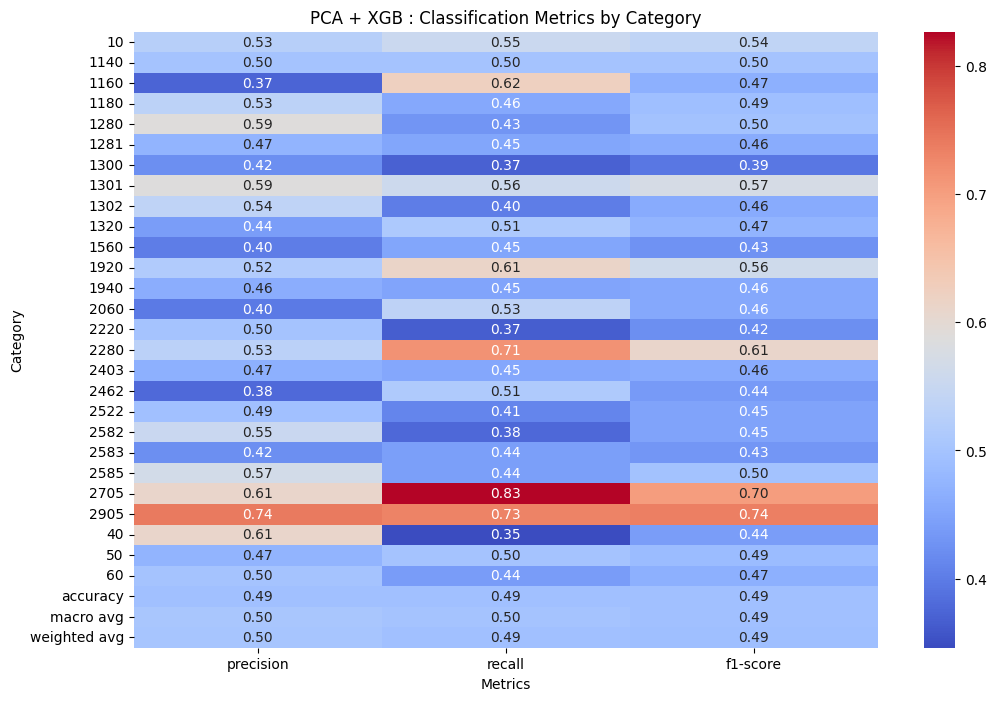

In [20]:
report_xgb = classification_report(y_test, y_pred, target_names = label_encoder.classes_, output_dict = True)
heatmap_metrics_by_category(report_xgb, 'PCA + XGB')

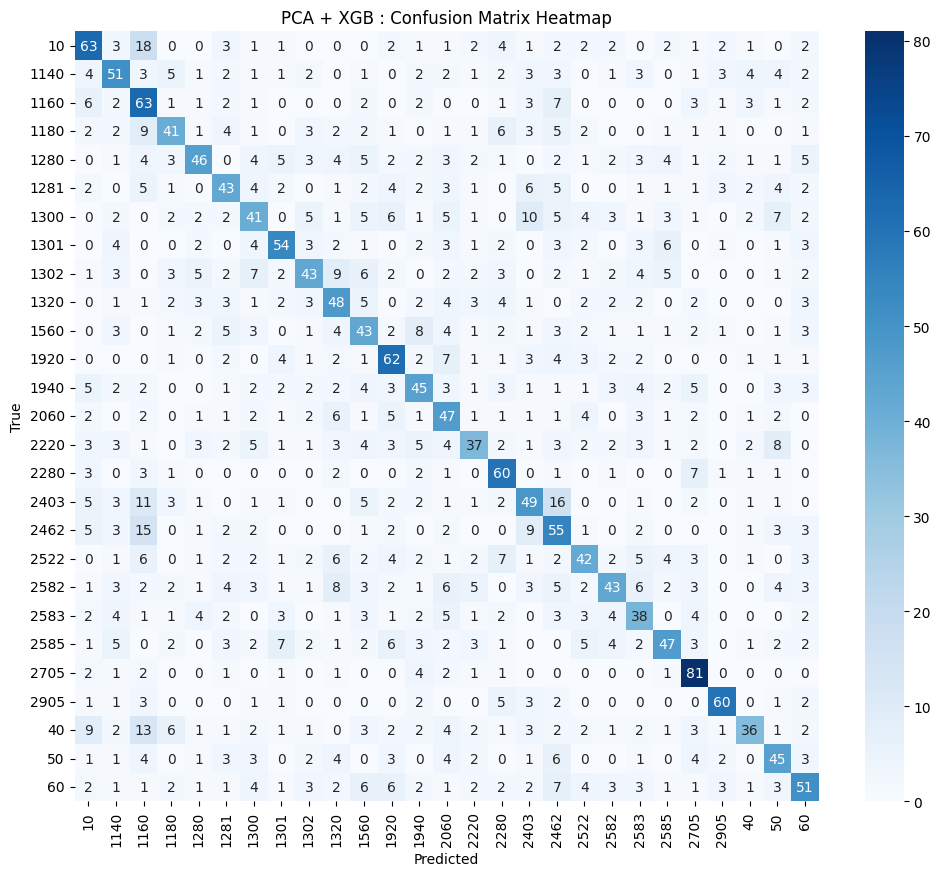

In [21]:
# matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# noms des classes
class_names = label_encoder.classes_

plt.figure(figsize = (12, 10))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = class_names, yticklabels = class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('PCA + XGB : Confusion Matrix Heatmap')
plt.show()

## Conclusions:

- Accuracy et f1-score autour de 0.49, les résultats sont très similaires au RandomForest sans amélioration des performances significatives
- On remarque encore une fois que les classes 2705 et 2905 obtiennent d'assez bons résultats, là où d'autres sous-performent, comme la 1300

L'entraînement d'un XGBoost n'a apporté aucune amélioration de la prédiction, et la durée d'entraînement a été plus longue (2m48)
 

# Réduction Umap

Justification du choix:
- Permet de capturer des relations non linéaires dans les données (comme LLE et t-SNE)
- adapté aux données complexes et volumineuses
- rapide
- Préserve les structures locales et globales des données
- flexibilité des hyperparamètres

On va commencer par une réduction en 2 dimensions

In [9]:
umap_model = umap.UMAP(n_components = 2, random_state = 42)
images_umap = umap_model.fit_transform(images)


c:\Users\Louis Valentin\source\repos\bootcamp-mle24-rakuten\env\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\Louis Valentin\source\repos\bootcamp-mle24-rakuten\env\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


## Visualisation

On projette les points obtenus par cette réduction 2D

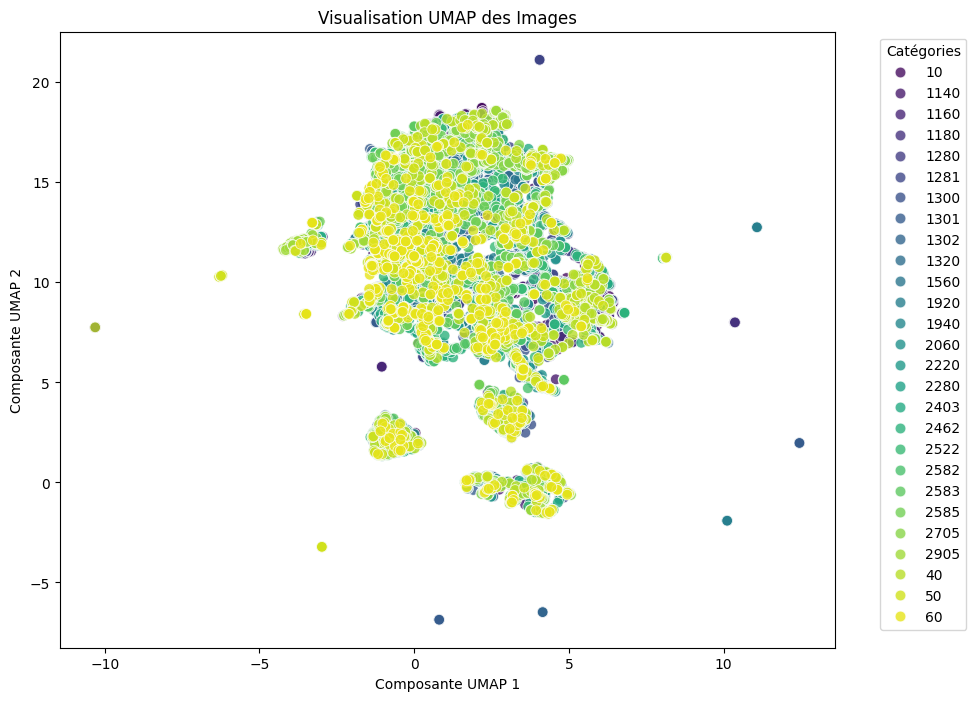

In [35]:
plt.figure(figsize = (10, 8))

# Tracage scatterplot des points
sns.scatterplot(x = images_umap[:, 0], y = images_umap[:, 1], hue = labels, palette = "viridis", s = 60, alpha = 0.8)
plt.title('Visualisation UMAP des Images')
plt.xlabel('Composante UMAP 1')
plt.ylabel('Composante UMAP 2')
plt.legend(title = 'Catégories', bbox_to_anchor = (1.05, 1), loc = 'upper left')
plt.show()



A première vue, les 2 dimensions ne semblent pas suffisantes pour séparer les points de données.  
  
On va essayer de trouver les paramètres optimaux de umap pour la réduction de dimension avec GridSearchCV

## Recherche des paramètres optimaux Umap avec un RF Classifier

In [11]:
# umap + classifier
umap_model = umap.UMAP(random_state = 42)
classifier = RandomForestClassifier(random_state = 42)

pipeline = Pipeline([
    ('umap', umap_model),
    ('classifier', classifier)
])

# paramètres à tester
param_grid = {
    'umap__n_neighbors': [5, 10, 15],
    'umap__min_dist': [0.0, 0.1, 0.3],
    'umap__n_components': [2, 5, 10],
    'umap__metric': ['euclidean'],
    'classifier__n_estimators': [50, 100, 200]
}

# Recherche des meilleurs paramètres avec GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, scoring = make_scorer(accuracy_score), n_jobs = -1, cv = 3, verbose = 1)
grid_search.fit(images, labels_encoded)

# Best params
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation accuracy: ", grid_search.best_score_)


Fitting 3 folds for each of 81 candidates, totalling 243 fits


c:\Users\Louis Valentin\source\repos\bootcamp-mle24-rakuten\env\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Best parameters found:  {'classifier__n_estimators': 200, 'umap__metric': 'euclidean', 'umap__min_dist': 0.3, 'umap__n_components': 10, 'umap__n_neighbors': 10}
Best cross-validation accuracy:  0.1445925925925926


Au vu des résultats qu'on obtient (0.14 acc) avec les meilleurs paramètres, nous concluons que des modèles baseline de réduction de dimension ne seront pas suffisants pour différencier nos catégories.